### KEM
This is a simulation of an economic micro interations, in which each time step two actors, which are chosen by an interaction function, engage in a transaction that exchanges wealth between them according to a specific transaction function.

This code has been modified from https://nbviewer.jupyter.org/url/norvig.com/ipython/Economics.ipynb

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import statistics
import warnings
import numpy as np
import copy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
warnings.filterwarnings("ignore")

In [45]:
#initial values (population size & mean of the income distribution)
N  = 500
MU = 100. 

# Initial income distribution

def normalize(numbers, mu):
    
    '''
    Positive values, and scale them so they have mean mu.
    
    '''
    
    numbers = [max(0, n) for n in numbers]
    
    factor = len(numbers) * mu / sum(numbers)
    
    return [x * factor for x in numbers]

def samples(distribution, *args, n = N, mu = MU):
    '''
    Sample from the distribution n times,
    then normalize results.
    
    '''
    
    numbers = [distribution(*args) for _ in range(N)]
    return normalize(numbers, mu)


def generate_population(n=N,pop_type="IPDO"):
    population = [np.random.uniform(0, 100) for actor in range(n)]
    #TODO: use from paper, find value
    #lambda_ = np.random.lognormal(-1.5, 0.45, N)
    if pop_type == "IPDO":
        lambda_ = np.random.power(0.3,n)
        i = 0
        # make sure no lambdas are above 1
        for l in lambda_:
            if l >=1.:
                lambda_[i] = np.random.pareto(.3)
                if lambda_[i]>=1.:
                    lambda_[i] = 0.9
            i+=1
    if pop_type == "IPDO":
        return population,lambda_
    else:
        return population

            
    
    
    
population,lambda_ = generate_population(N)

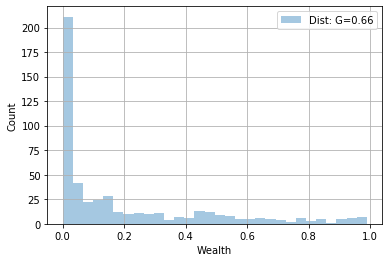

In [48]:
population
hist(lambda_)

In [49]:
def gini(p):
    
    "Gini coefficient (equation from wikipedia)"
    
    y = sorted(p)
    n = len(p)
    
    numer = 2 * sum((i+1) * y[i] for i in range(n))
    denom = n * sum(y)
    
    return (numer / denom) - (n + 1) / n


In [50]:
def hist(population, label='Dist', **kwargs):
    label = label + ': G=' + str(round(gini(population), 2))
    
    h = plt.hist(list(population), alpha = 0.4, bins = 30, label= label, **kwargs)
    
    plt.xlabel('Wealth')
    plt.ylabel('Count')
    plt.grid(True)
    
    plt.legend()

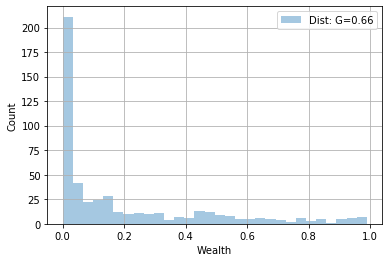

In [51]:
hist(lambda_)

In [52]:
# Type of Transactions

def swd(A, B):
    # this need to change after
    eps = np.random.uniform()
    
    
    return lambda_[A]*population[A] + eps*((1-lambda_[A]) * population[A] + (1 - lambda_[B])*population[B]), lambda_[B]*population[B] + (1-eps)*((1 - lambda_[A]) * population[A] + (1 - lambda_[B])*population[B]) 
    


In [53]:
# Type of Interactions 

def anyone(N): 
    '''
    Takes two actors randomly
    
    '''
    return random.sample(range(N), 2)

In [54]:
# Simulation

def simulate(population, steps, transaction=swd, interaction=anyone):
    '''
    Simulate takes a certain initial population, and makes them interact.
    
    Inputs:
        population. list. Initial income distribution
        steps. int. Time steps to execute the simulation
        transaction. function. function that describes the dynamic of the transaction.
        interaction. function. function that describes the dynamic of the interaction.
    
    Outputs:
        population after steps number of steps. 
    
    '''
    
    population = population.copy()
   # yield population
 
    for t in range(steps):
        i, j = interaction(len(population))
        population[i], population[j] = transaction(i,j)
        
        yield population
        

In [66]:
def run(population, k=500, **kwargs):
    
    '''
    Run a simulation for k*N steps, returning results
    
    '''
    
    N = len(population)
    start = list(population)
    
    results = []
    sorted_results = []
    times = []
    #print("nsteps = ",str((k*N)))
    
    for (t, pop) in enumerate(simulate(population, k * N, **kwargs)):
        if t % (N / 10) == 0:
            results.append(copy.copy(pop))
            sorted_results.append(sorted(pop))
            times.append(copy.copy(t))
    

    return results,sorted_results,times
    


def show(population, k=500, percentiles=(1, 10, 50, 90, 99), **kwargs):
    
    '''
    Run a simulation for k*N steps, 
    printing statistics and displaying a plot and histogram.
    
    '''
    N = len(population)
    start = list(population)
            
    results,sorted_results,times = run(population, k, **kwargs)
    
    
    
    # Statistics
    
    print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))
    
    
    fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
    
    
    initsum = sum(population)
    for (t, pop) in zip(times,sorted_results):
        err = (sum(pop) - initsum)/initsum
        #print(err)
        if t % (4 * N) == 0:
            #NOT EQUAL TO SAME SUM EVERY TIME!!! but close??? 
           
            data = [percent(pct, pop) for pct in percentiles]
            print(fmt.format(t, gini(pop), statistics.stdev(pop), *data))
            
            
#     #plot individual trajectory
#     plt.hold(True)
#     plt.xlabel('Time')
#     plt.ylabel('Wealth')
#     plt.grid(True)
#     plt.plot(times, lists)

#     plt.show()
    
    
    
    
    
    # Plot
    
#     plt.xlabel('Time')
#     plt.ylabel('Wealth')
#     plt.grid(True)
    
#     for pct in percentiles:
#         #TODO: this should average over all people in different percentiles, or make a separate thing to do that
#         line = [percent(pct, pop) for pop in results]
#         plt.plot(times, line)

#     plt.show()
    
    
    # Histogram
    pop = results[-1]
    R = (min(pop+start), max(pop+start))
    hist(start, 'Initial', range=R)
    hist(pop, 'Final', range=R)
    plt.show()
    plt.close()
    
    return results
                
def percent(pct, items):
    '''
    The item that is pct percent through the sorted list of items.
    
    '''
    return items[min(len(items)-1, len(items) * pct // 100)]



def animate_distributions(pop_series,continuous=True,times=[0,1],n_frames=100):
    #if continuous:
    run_times = []
    
    
    duration = times[1]-times[0]
    tstep = round(float(duration)/n_frames)
    
    max_t = len(pop_series)

    fig = plt.figure()
    def animate(i):
        #label = label + ': G=' + str(round(gini(population), 2))
        plt.cla()
        time = times[0]+i*tstep
        if time < max_t:
            # take average 
            plotvals = np.average(pop_series[time:(time+tstep)],axis=0)
            plt.hist(plotvals, alpha = 0.4, bins = 30, label=str(time))
            plt.legend()
            plt.xlabel('Wealth')
            plt.ylabel('Count')
            plt.grid(True)
       
    anim = FuncAnimation(fig, animate, #init_func=init,
                                   frames=n_frames)#), interval=20)#, blit=True)
    HTML(anim.to_jshtml())
    return anim



def test_stability(pop_series,n_steps=50,end_time=1000):
    pop_series = np.array(pop_series)
    t_series = pop_series[(end_time-n_steps):end_time]
    stds = []
    mus = []
    for agent_n in range(len(t_series[0])):
        agent_series = t_series[:,agent_n]
        std = np.std(agent_series)
        stds.append(std)
        mus.append(np.mean(agent_series))
    plt.figure()
    plt.hist(stds)
    xlbl = "standard deviations of wealth (unit=absolute wealth); t=["+str(end_time-n_steps)+","+str(end_time)+"]"
    plt.xlabel(xlbl)
    plt.show()
    
    
    stds,mus = np.array(stds),np.array(mus)
    plt.figure()
    plt.hist((stds/mus))
    xlbl = "standard deviations of wealth (unit=percent wealth); t=["+str(end_time-n_steps)+","+str(end_time)+"]"
    plt.xlabel(xlbl)
    plt.show()
    

   t    Gini stdev   1%  10%  50%  90%  99%
      0 0.32  27.8    1   11   47   88   99
  2,000 0.39  34.8    2   11   43  102  146
  4,000 0.38  34.3    2   11   45  100  147
  6,000 0.38  34.9    3   10   44  101  146
  8,000 0.38  33.9    1   10   44   97  142
 10,000 0.38  33.8    2   10   44   97  147
 12,000 0.39  34.1    2   11   42   93  154
 14,000 0.39  34.4    2   10   43  102  143
 16,000 0.37  33.8    2   12   46  100  147
 18,000 0.39  36.0    2   12   45  103  145
 20,000 0.38  33.4    2   10   43   98  130
 22,000 0.40  35.2    2    8   43  100  148
 24,000 0.38  33.8    2   10   43   94  151
 26,000 0.38  34.4    2    8   42   98  148
 28,000 0.39  33.9    1   10   44   96  143
 30,000 0.37  33.2    1   11   43   97  144
 32,000 0.36  31.7    1   12   42   92  146
 34,000 0.38  34.3    1   11   44  101  147
 36,000 0.38  33.0    1    8   44   99  134
 38,000 0.38  34.0    1   11   44   96  148
 40,000 0.39  34.1    1    7   43   97  149
 42,000 0.37  33.7    1   11   4

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



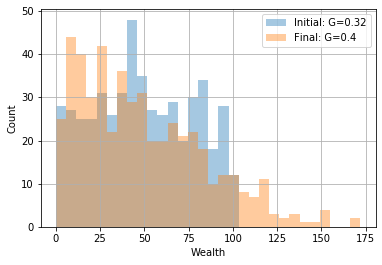

   t    Gini stdev   1%  10%  50%  90%  99%
      0 0.32  27.9    1   11   47   88   99
  2,000 0.38  33.6    2   10   46   97  139
  4,000 0.39  36.2    2   10   46  100  146
  6,000 0.37  32.2    2   10   45   95  134
  8,000 0.38  34.5    2   10   42  102  144
 10,000 0.39  36.0    2    9   45  103  161
 12,000 0.39  36.2    2   10   45  105  157
 14,000 0.40  36.7    1    9   45  104  150
 16,000 0.39  34.4    2   10   41   98  146
 18,000 0.38  34.2    1   11   45  101  136
 20,000 0.38  33.3    2   10   46   96  140
 22,000 0.38  33.0    2   11   43   96  138
 24,000 0.38  33.0    1   10   43   97  134
 26,000 0.39  33.6    1    9   45   98  138
 28,000 0.39  35.8    1   10   44  101  149
 30,000 0.39  35.0    1    8   44  100  145
 32,000 0.39  33.8    2   10   42   97  152
 34,000 0.40  35.1    1    9   42   98  146
 36,000 0.38  34.4    3    9   45  101  141
 38,000 0.38  34.2    2    9   44  100  143
 40,000 0.38  34.4    1   10   44   99  141
 42,000 0.38  33.4    2    9   4

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



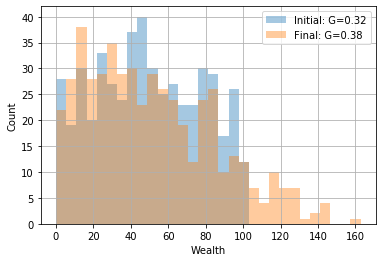

In [56]:
results = show(population)
results = show(population)


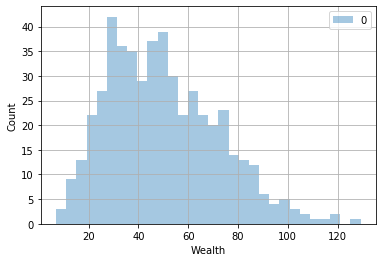

In [58]:
anim = animate_distributions(results,continuous=True,times=[0,3200],n_frames=50)
HTML(anim.to_jshtml())

In [61]:
test_stability(results)

IndexError: index 0 is out of bounds for axis 0 with size 0


 NEW SIM
population =  100


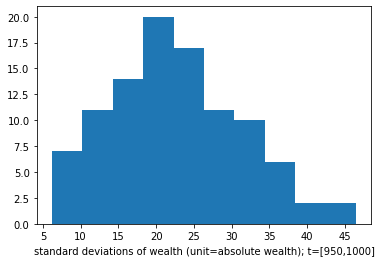

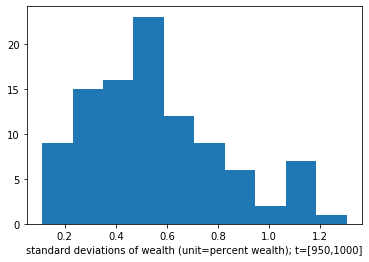


 NEW SIM
population =  200


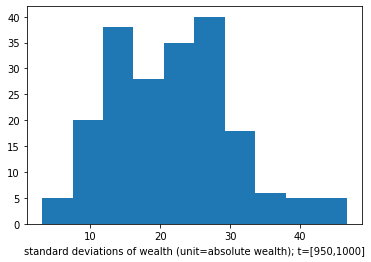

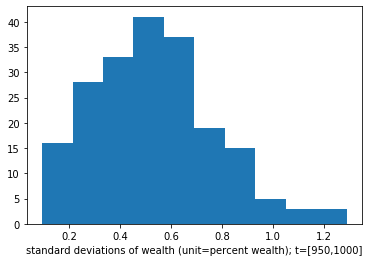


 NEW SIM
population =  300


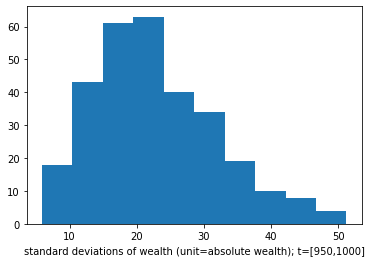

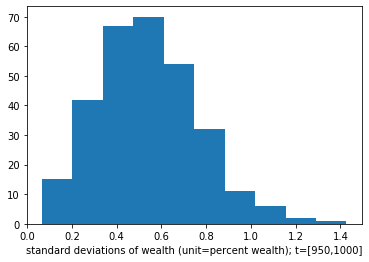


 NEW SIM
population =  400


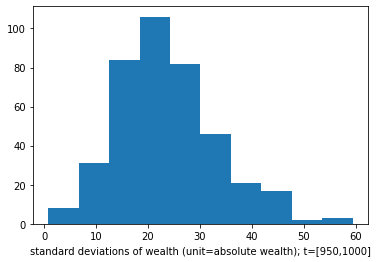

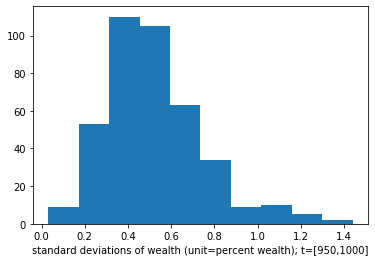


 NEW SIM
population =  500


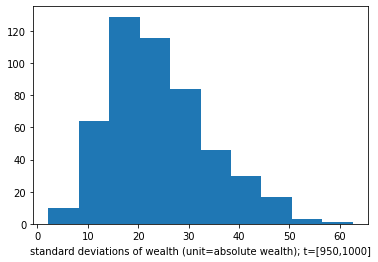

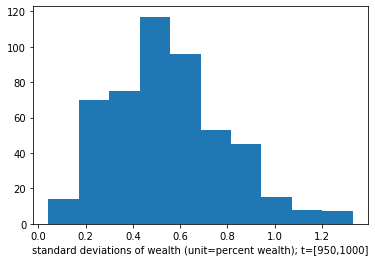


 NEW SIM
population =  600


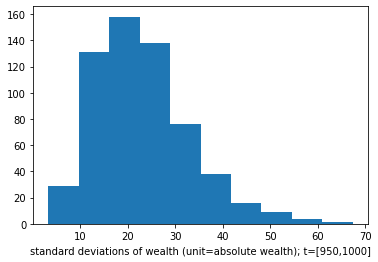

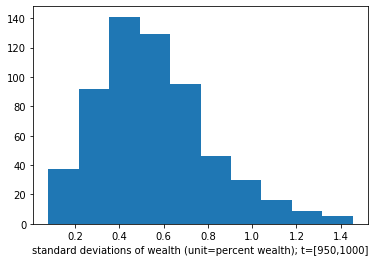


 NEW SIM
population =  700


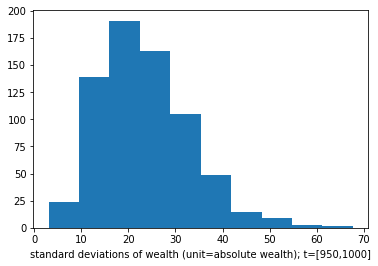

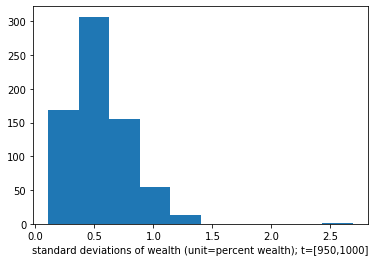


 NEW SIM
population =  800


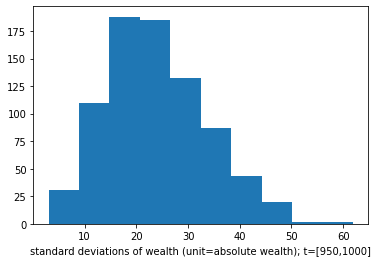

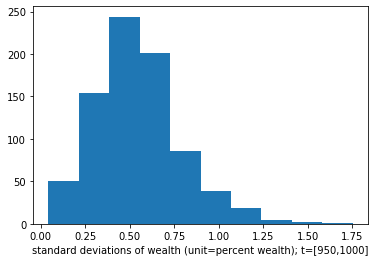


 NEW SIM
population =  900


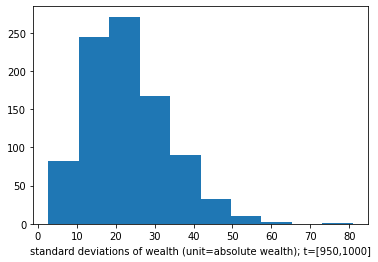

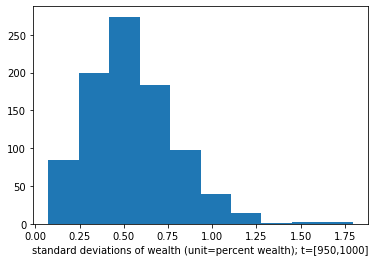


 NEW SIM
population =  1000


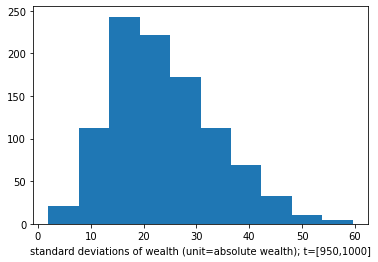

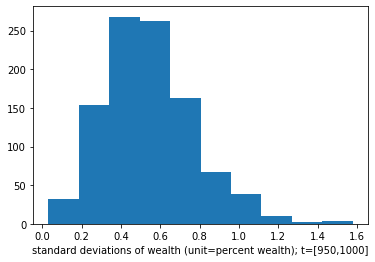


 NEW SIM
population =  1100


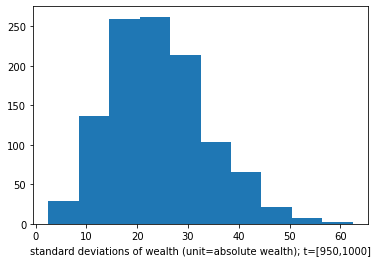

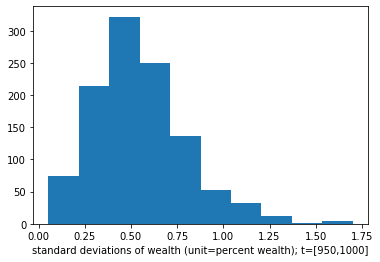


 NEW SIM
population =  1200


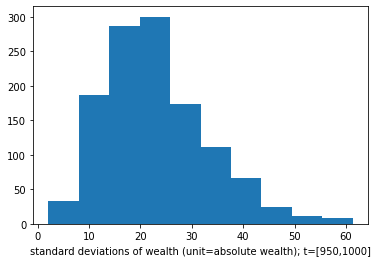

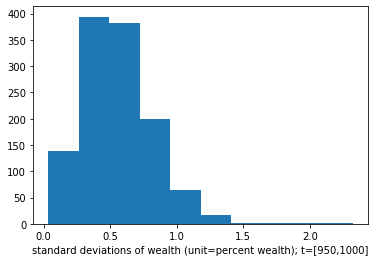


 NEW SIM
population =  1300


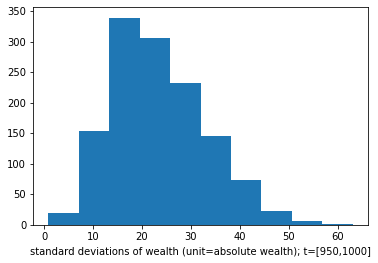

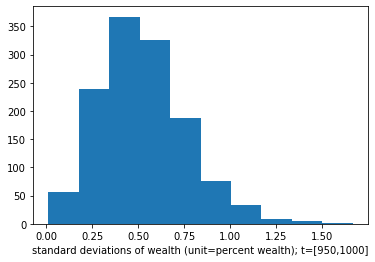


 NEW SIM
population =  1400


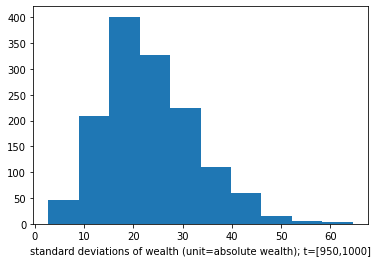

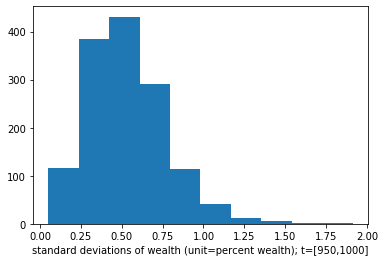


 NEW SIM
population =  1500


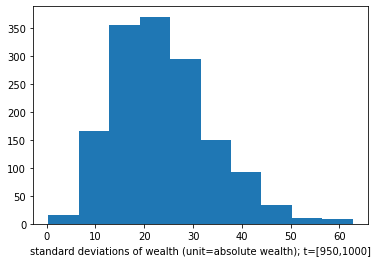

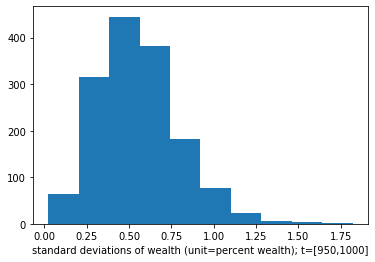


 NEW SIM
population =  1600


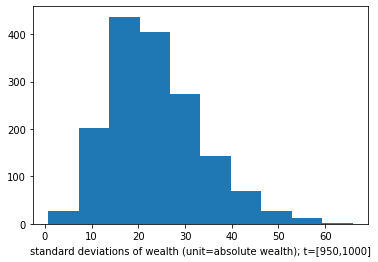

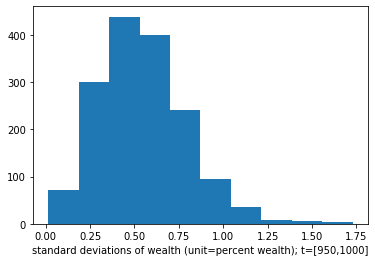


 NEW SIM
population =  1700


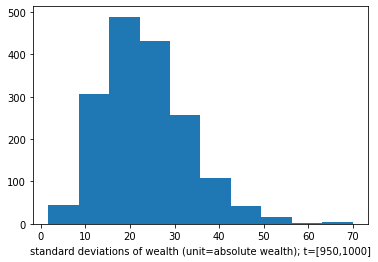

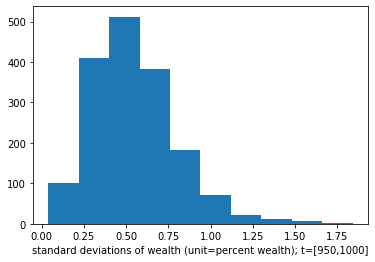


 NEW SIM
population =  1800


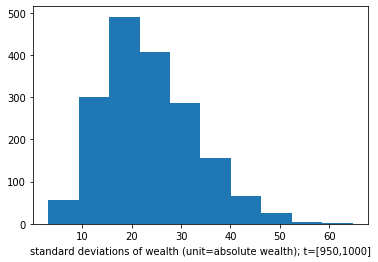

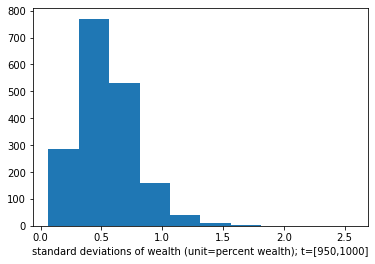


 NEW SIM
population =  1900


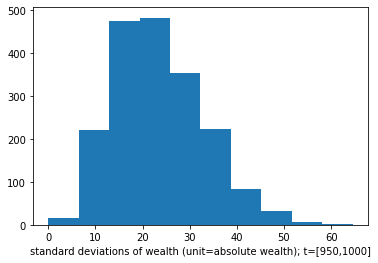

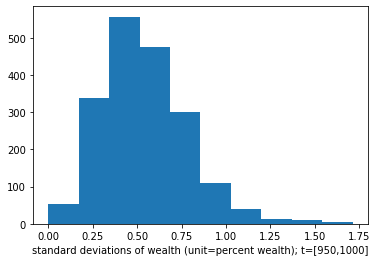


 NEW SIM
population =  2000


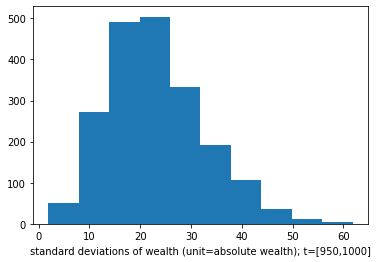

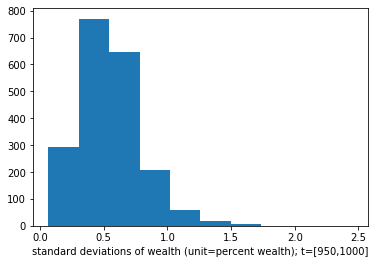


 NEW SIM
population =  2200


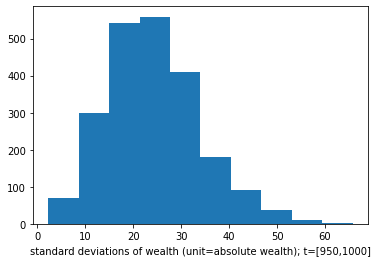

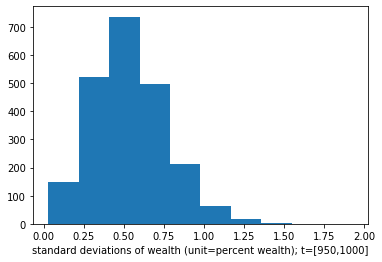


 NEW SIM
population =  2300


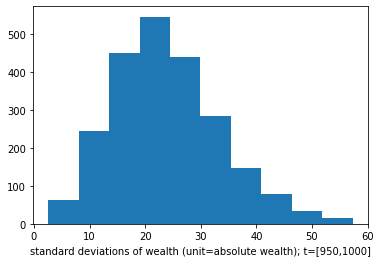

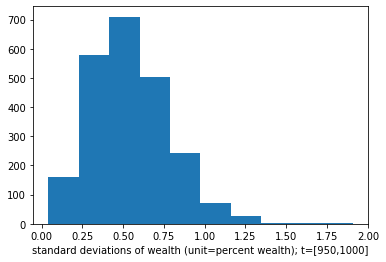


 NEW SIM
population =  2400


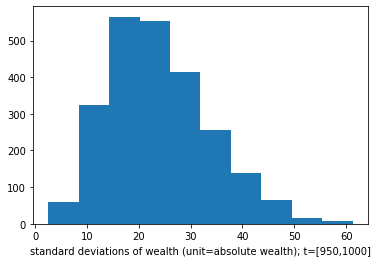

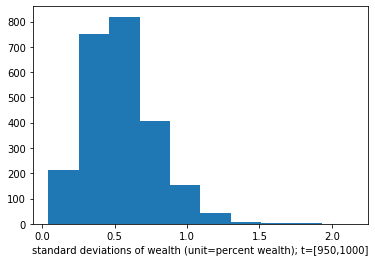


 NEW SIM
population =  2500


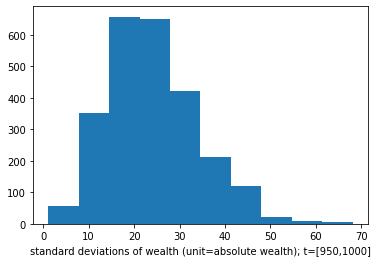

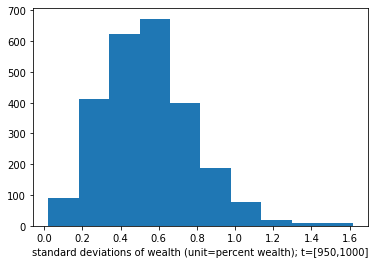


 NEW SIM
population =  2700


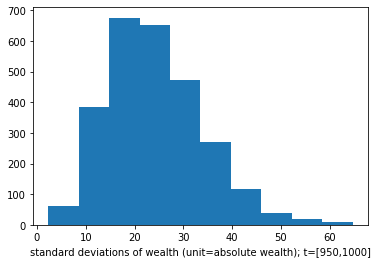

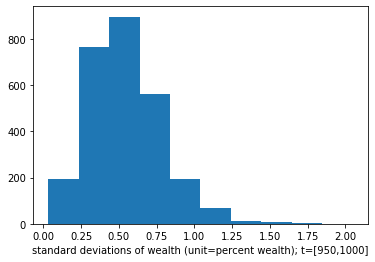


 NEW SIM
population =  3100


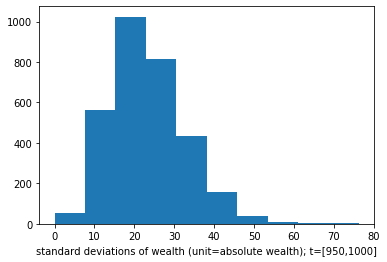

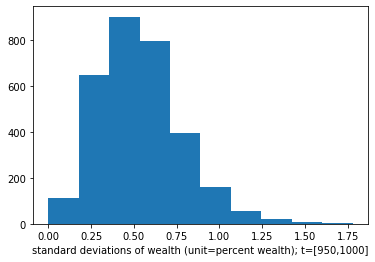


 NEW SIM
population =  3200


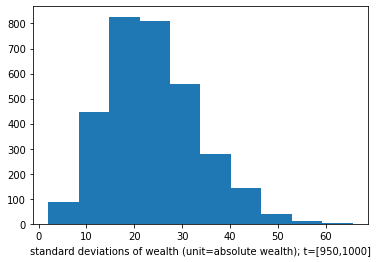

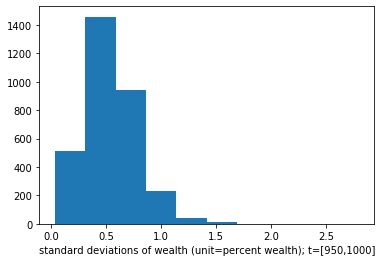


 NEW SIM
population =  3400


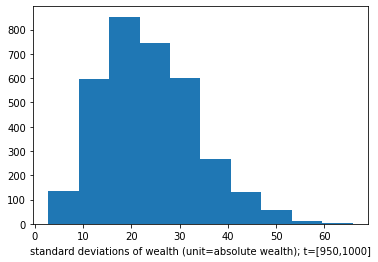

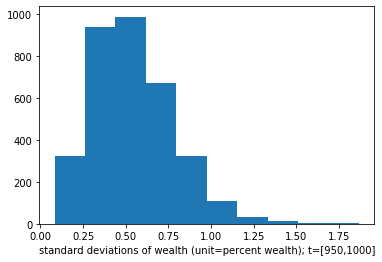


 NEW SIM
population =  3500


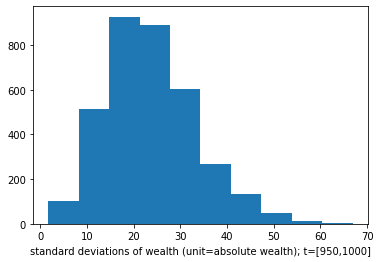

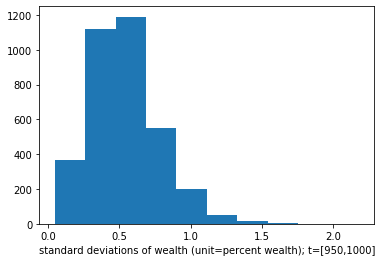


 NEW SIM
population =  3600


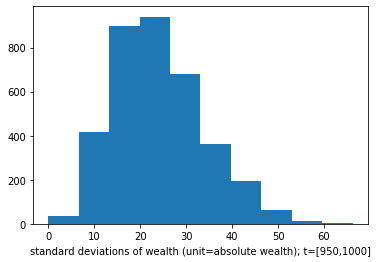

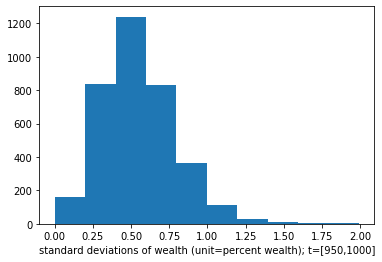


 NEW SIM
population =  3900


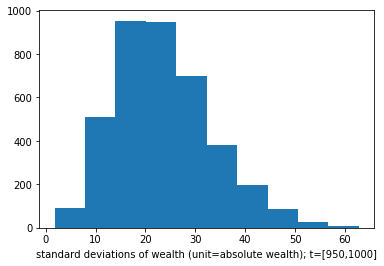

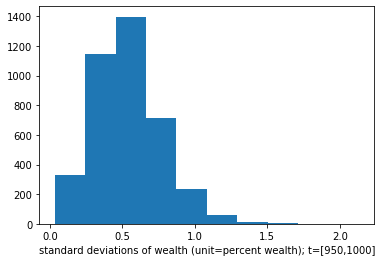


 NEW SIM
population =  4000


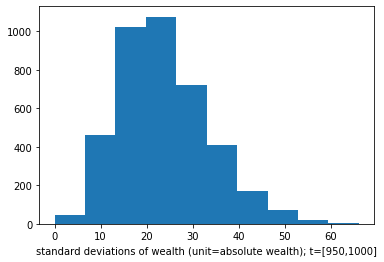

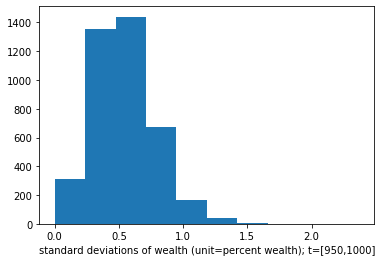


 NEW SIM
population =  4400


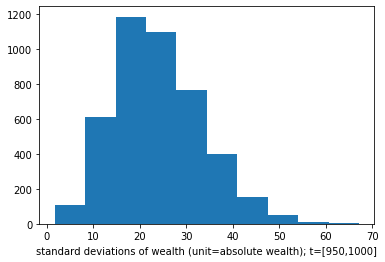

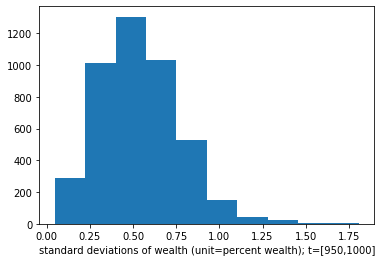


 NEW SIM
population =  5200


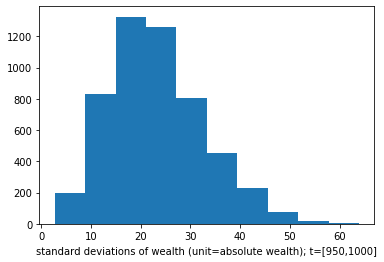

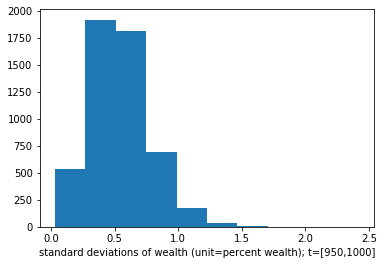


 NEW SIM
population =  6200


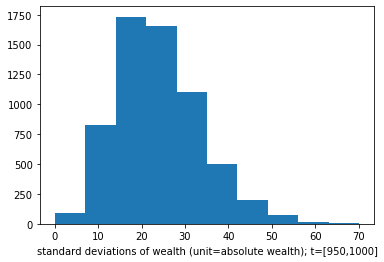

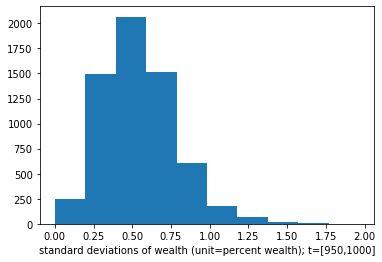


 NEW SIM
population =  6400


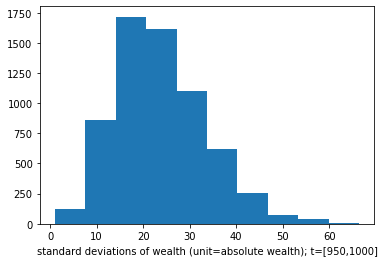

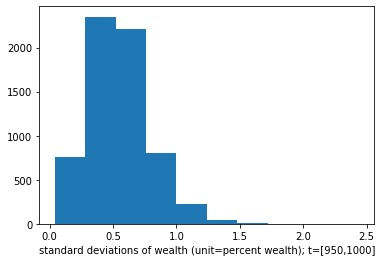


 NEW SIM
population =  6700


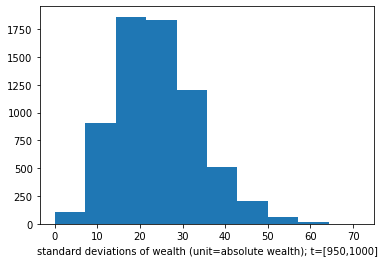

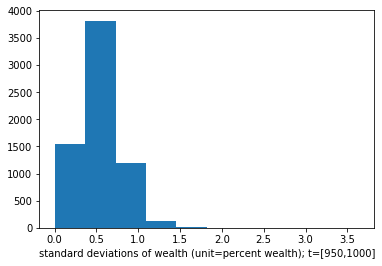


 NEW SIM
population =  6900


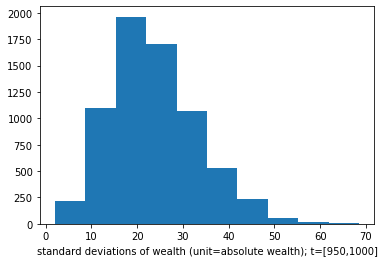

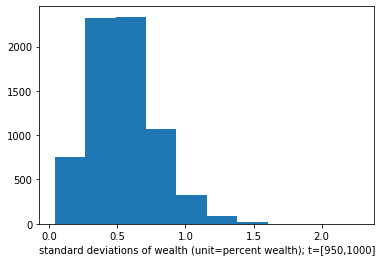


 NEW SIM
population =  7700


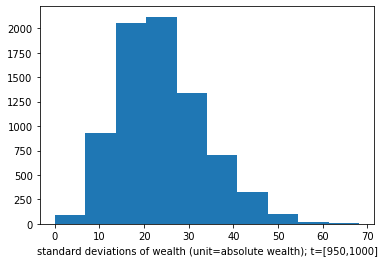

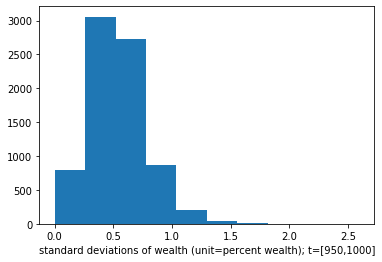


 NEW SIM
population =  7800


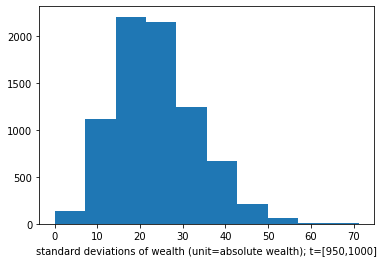

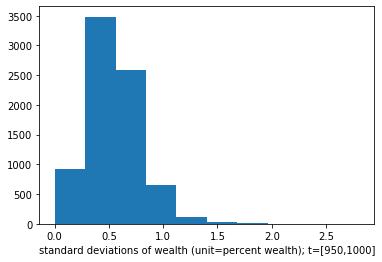


 NEW SIM
population =  7900


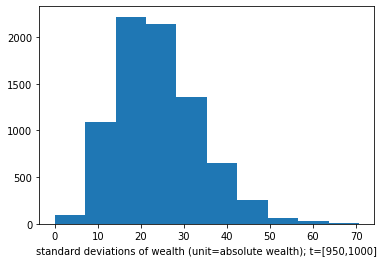

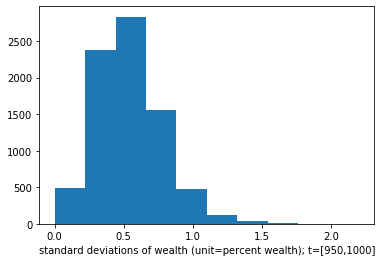


 NEW SIM
population =  8000


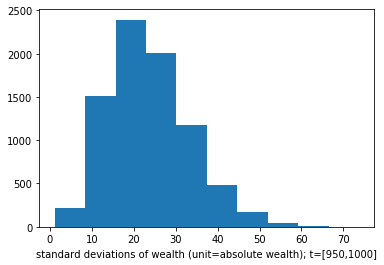

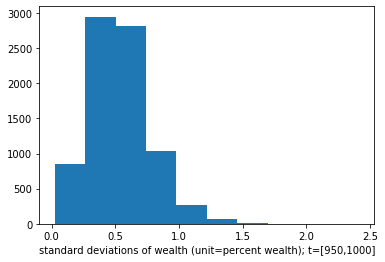


 NEW SIM
population =  8100


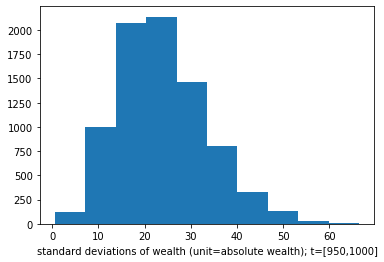

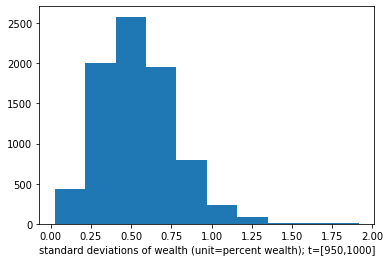


 NEW SIM
population =  8200


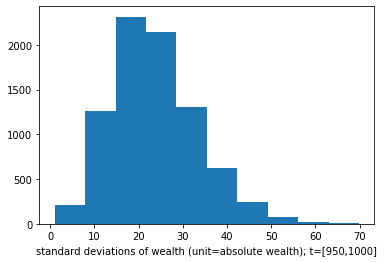

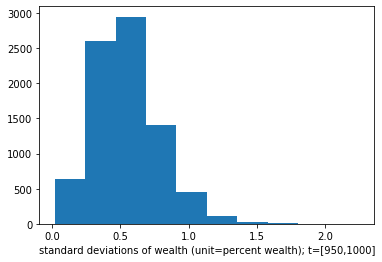


 NEW SIM
population =  8300


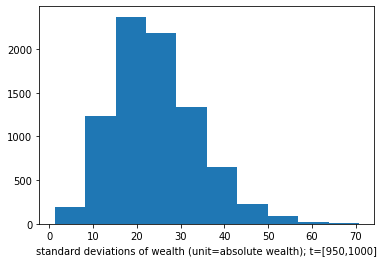

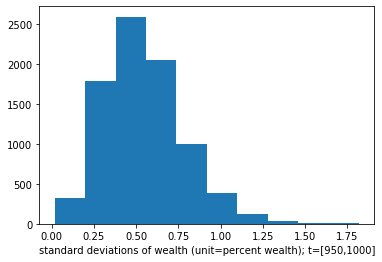


 NEW SIM
population =  8800


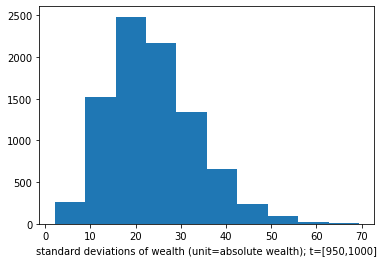

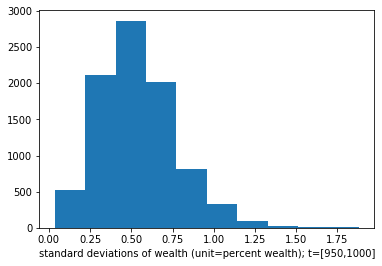


 NEW SIM
population =  9200


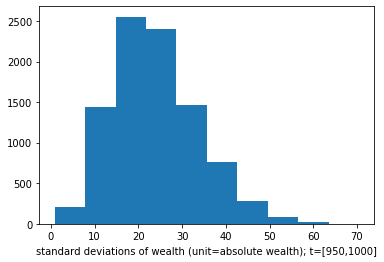

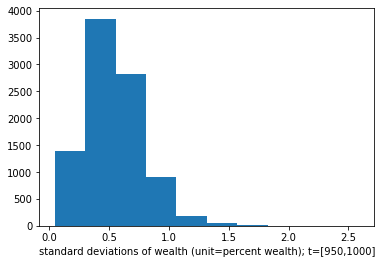


 NEW SIM
population =  9300


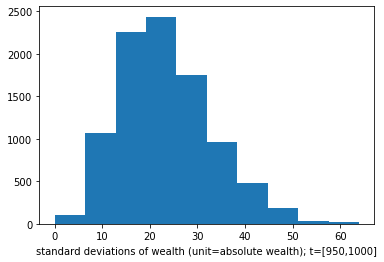

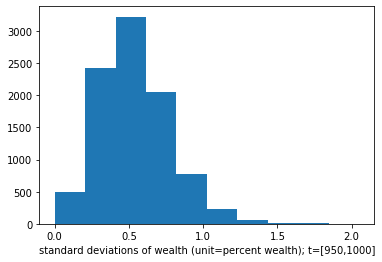


 NEW SIM
population =  11300


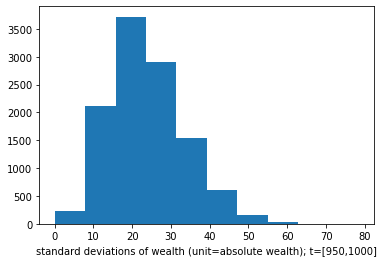

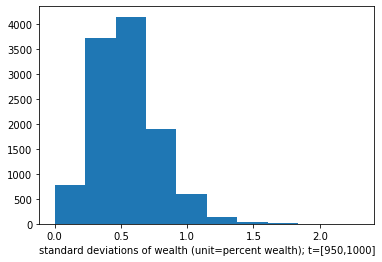


 NEW SIM
population =  11600


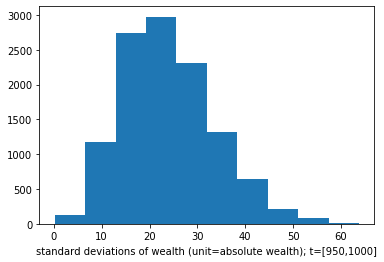

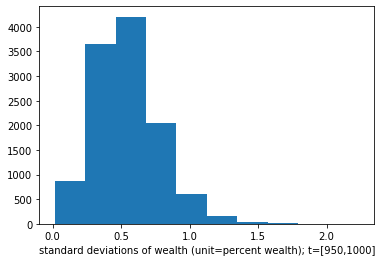


 NEW SIM
population =  11700


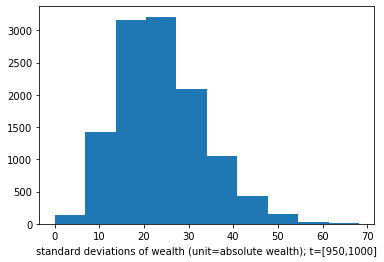

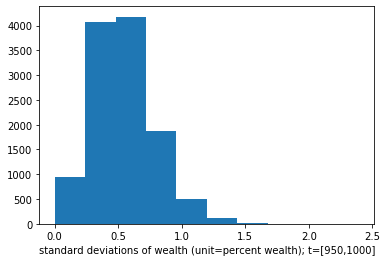


 NEW SIM
population =  12400


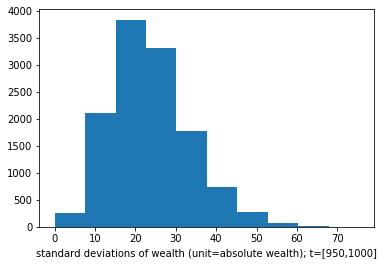

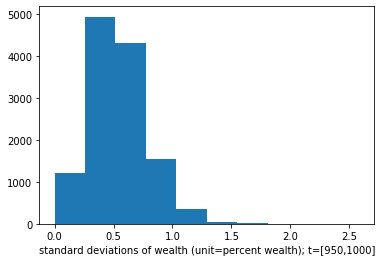


 NEW SIM
population =  13000


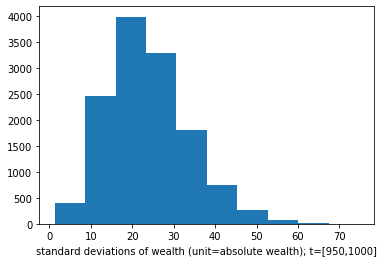

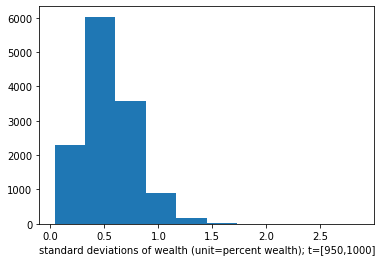


 NEW SIM
population =  13300


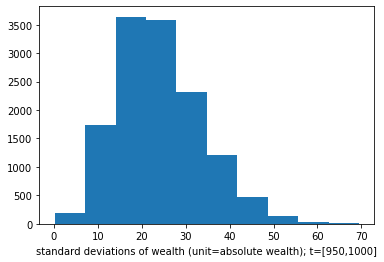

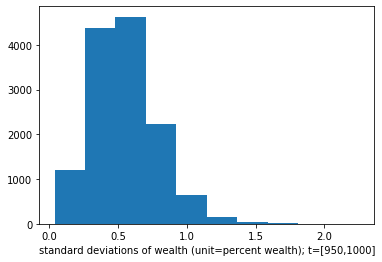


 NEW SIM
population =  14000


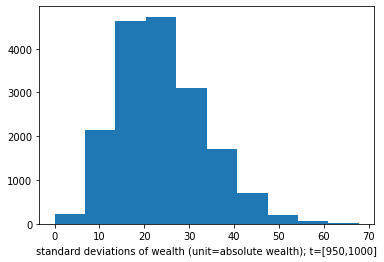

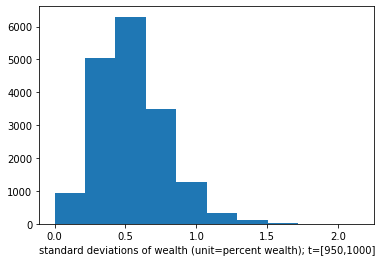


 NEW SIM
population =  27100


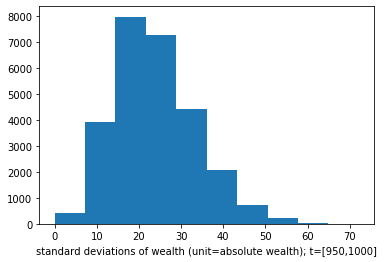

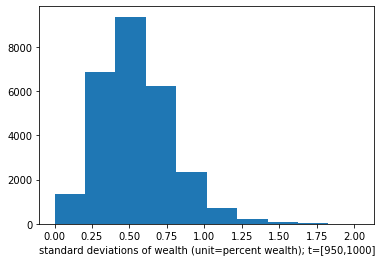


 NEW SIM
population =  28800


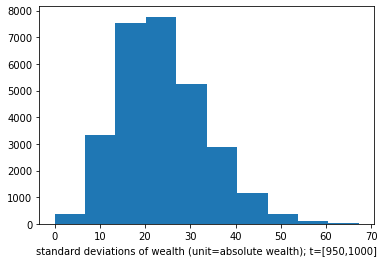

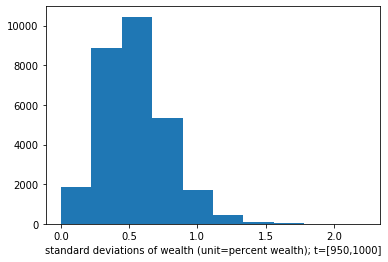


 NEW SIM
population =  32900


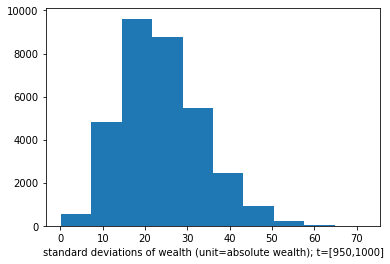

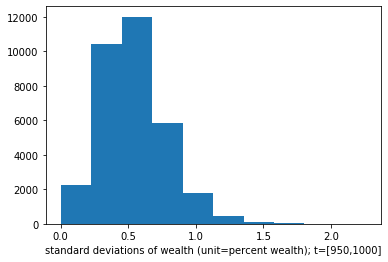


 NEW SIM
population =  40700


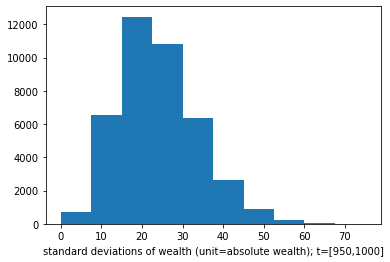

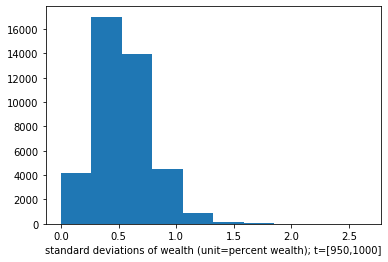


 NEW SIM
population =  41300


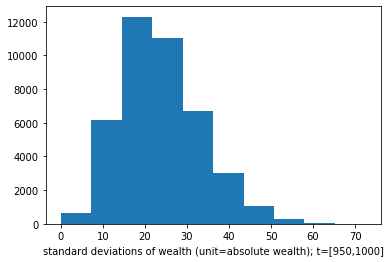

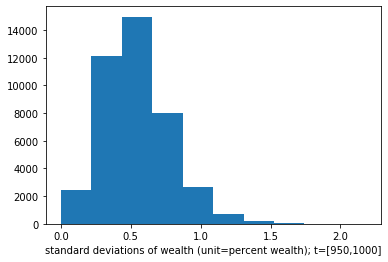


 NEW SIM
population =  44500


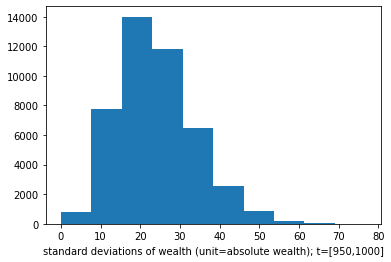

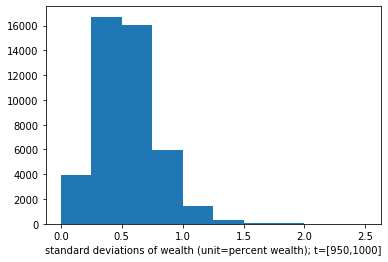


 NEW SIM
population =  49700


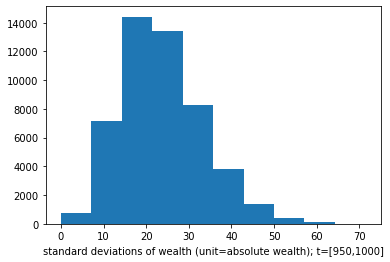

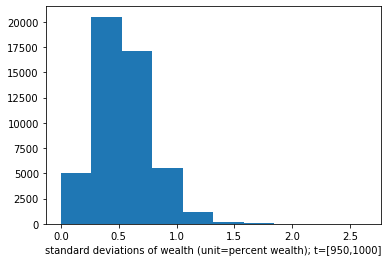


 NEW SIM
population =  51400


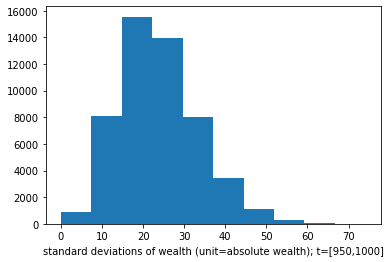

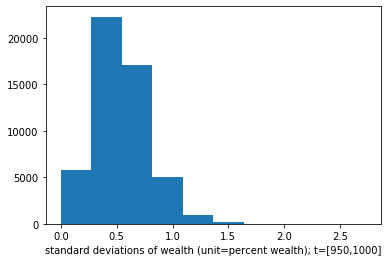


 NEW SIM
population =  58700


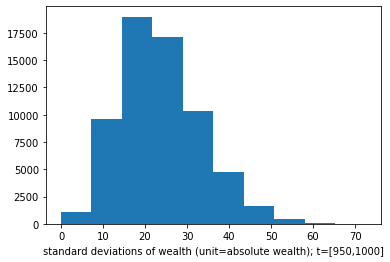

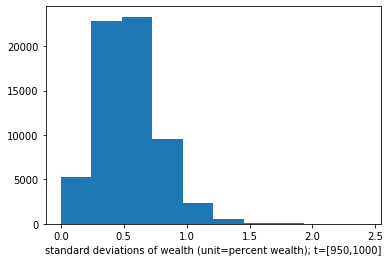


 NEW SIM
population =  66000


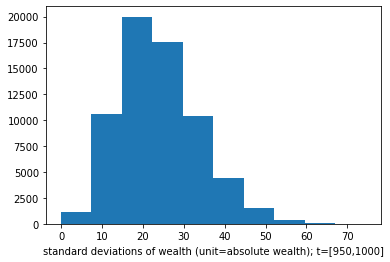

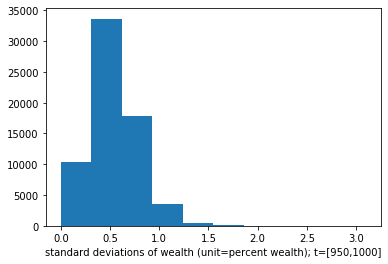


 NEW SIM
population =  73600


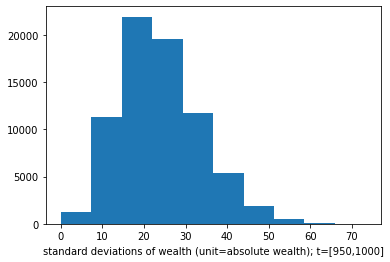

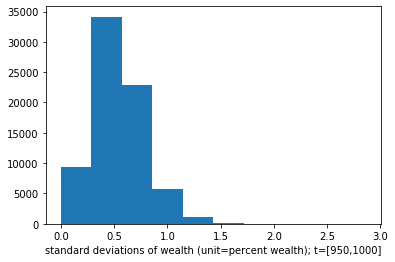


 NEW SIM
population =  77800


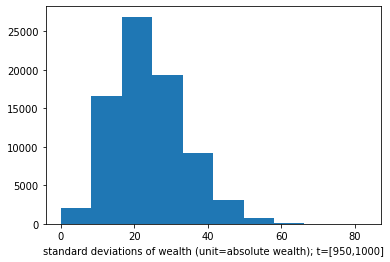

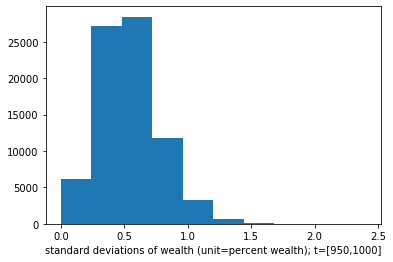


 NEW SIM
population =  104200


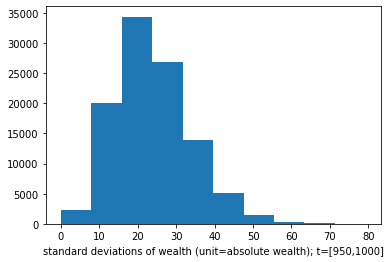

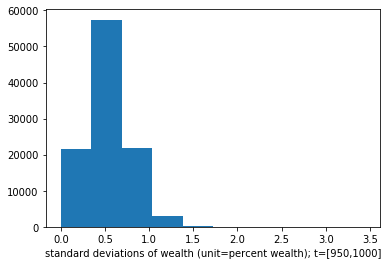


 NEW SIM
population =  204100


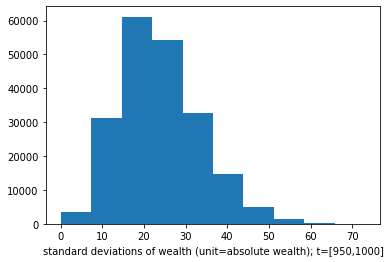

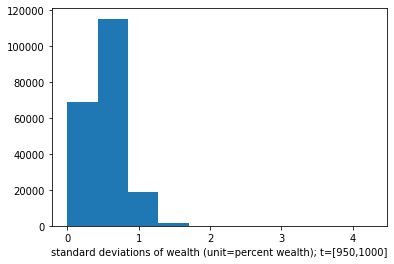


 NEW SIM
population =  263100


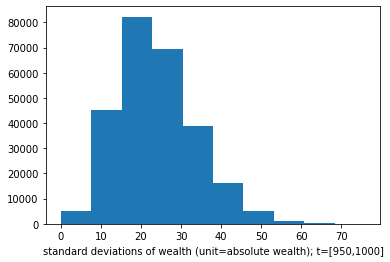

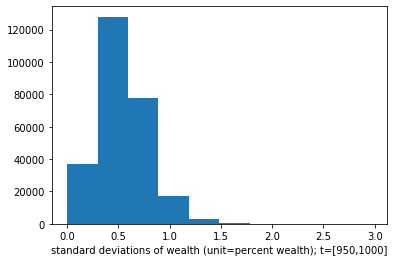


 NEW SIM
population =  289900


KeyboardInterrupt: 

In [74]:
# generated by zipf's law distribution
hists = []
popsizes = np.unique(np.random.zipf(1.4,300)*100)[:-8]
for popsize in popsizes:
    population,lambda_ = generate_population(popsize)
    print("\n NEW SIM\npopulation = ",popsize)
    results,_,_ = run(population,k=200)
    hists.append(results[-1])
#     test_stability(results)

    


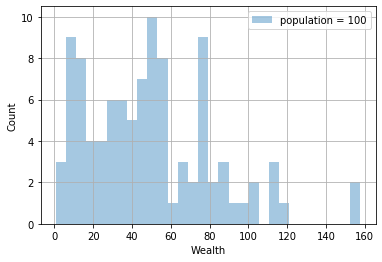

In [77]:

fig = plt.figure()

def animate(i):
    #label = label + ': G=' + str(round(gini(population), 2))
    plt.cla()
    lbl = "population = "+str(popsizes[i])
    plt.hist(hists[i], alpha = 0.4, bins = 30, label=lbl)
    plt.legend()
    plt.xlabel('Wealth')
    plt.ylabel('Count')
    plt.grid(True)

anim = FuncAnimation(fig, animate, #init_func=init,
                               #frames=76)#), interval=20)#, blit=True)
                               frames=len(hists))#), interval=20)#, blit=True)
HTML(anim.to_jshtml())


In [73]:

test_stability(hists[-1])

TypeError: object of type 'numpy.float64' has no len()